<div style="border:solid Chocolate 2px; padding: 40px">

Привет, меня зовут Александр Куимов. Я буду ревьюером твоего проекта. Ты можешь обращаться ко мне на "ты"😏 Надеюсь, тебя также не смутит, если я буду обращаться к тебе на "ты", но если это неудобно, обязательно скажи об этом!

**Пожалуйста, не перемещай, не изменяй и не удаляй мои комментарии**, они будут особенно полезны для нашей работы в случае повторной проверки проекта. 

Прошу реагировать на все мои комментарии, по которым ты вносишь правки в проект, своими комментариями по шаблону, показанному чуть ниже. На каждое мое замечание нужно отвечать комментарием студента в маркдаун ячейке **ниже моей. Это нужно, чтобы не создавалась путаница**.😉

Ты можешь найти мои комментарии, обозначенные <font color='green'>зеленым</font>, <font color='gold'>же лтым</font> и <font color='red'>красным</font> цветами, например:

<br/>
 
<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> В случае, если решение на отдельном шаге является полностью правильным.
</div>

<br/>
 
<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> В случае, когда решение на отдельном шаге станет еще лучше, если внести небольшие коррективы.
</div>


<br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку🤔:</b>
 В случае, когда решение на отдельном шаге требует существенной переработки и внесения правок. Напоминаю, что проект не может быть принят с первого раза, если ревью содержит комментарии, рекомендующие доработать шаги.
</div>
    
    
<br/>    
<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

<b>👋:</b> В такой цветовой ячейке - образце я прошу тебя оставлять твои комментарии. **Обязательно сохрани в нем заголовок "Комментарий студента" в каждой твоей ячейке**. Если исправляешь проект во второй раз и далее, не забывай пожалуйста указывать номер итерации, например, "Комментарий студента 2". У меня к этому моменту уже появится нумерация в моих комментариях.
</div> 

<br/>    
    
Увидев у тебя неточность, в первый раз я лишь укажу на ее наличие и дам тебе возможность самому найти и исправить ее. На реальной работе твой руководитель будет поступать также, и я пытаюсь подготовить тебя именно к работе датасаентистом. Но если ты пока не справишься с такой задачей - при следующей проверке я дам более точную подсказку!🤓
    
   **Если у тебя будут возникают какие-то сложности, связанные с выполнением этого проекта**, то я смогу отвечать тебе на вопросы только в ходе ревью до 24 часов на основании соглашения об уровне услуг SLA (это может быть любое время суток, даже ночью), и к сожалению, каждые из таких ревью расходуют доступные иттерации (их всего 6). 
Лучшее решение в подобных случаях - обратиться за помощью к преподавателю по проектам в треде для получения оперативных консультаций. На всякий случай акцентирую, что преподаватель отвечает в тредах, а в личку не отвечает. В редких случаях может возникнуть ситуация, когда преподаватель не ответил вовремя, в таком случае рекомендую связаться с куратором для оперативного решения вопроса.
    
   **Если у тебя будут возникают вопросы, которые не касаются проекта и моих комментариев в нем**, а касаются теории и спринта, то я смогу кратко тебе ответить, а подробнее на вопрос тебе ответит преподаватель и по запросу сможет подобрать материал адекватный текущему прогрессу курса (только нужно написать ему в тред) 🤓   

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка данных</a></span></li></ul></li><li><span><a href="#Исследовательский-анализ" data-toc-modified-id="Исследовательский-анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ</a></span></li><li><span><a href="#Подготовка-и-обучение-моделей" data-toc-modified-id="Подготовка-и-обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка и обучение моделей</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Прогнозирование заказов такси

**Цель проекта:**  
Разработать модель машинного обучения для предсказания количества заказов такси в аэропорту на следующий час. Это позволит компании «Чётенькое такси» оптимизировать распределение водителей в периоды пиковой нагрузки и улучшить качество обслуживания клиентов.

**Описание проекта:**  
Компания «Чётенькое такси» собирает данные о заказах такси, сделанных в аэропортах. На основе исторических данных необходимо предсказать количество заказов такси на следующий час. Построенная модель будет использоваться для оптимизации распределения водителей и повышения качества обслуживания в пиковые часы. Ключевая метрика — RMSE, значение которой должно быть не больше 48.

**Критерии, важные заказчику:**  
- Высокая точность предсказания (метрика RMSE на тестовой выборке не более 48).
- Оптимизация времени обучения модели.
- Возможность работы с историческими данными для корректного прогнозирования.

---

**Этапы выполнения проекта:**

**1. Загрузка и анализ данных**  
- Загрузить данные из файла `/datasets/taxi.csv`.
- Ознакомиться с общей структурой данных: столбцы, типы признаков, распределение данных.
- Проверить наличие пропусков, выбросов и аномалий в данных.

**2. Предобработка данных**  
- Привести данные к необходимому формату: выполнить ресемплирование данных по одному часу для временного ряда.

**3. Разделение данных**  
- Определить целевой признак (`num_orders`).
- Разделить выборку на обучающую и тестовую: тестовая выборка — 10% от всех данных.

**4. Построение и обучение моделей**  
- Создать pipeline для обработки данных и обучения моделей.
- Обучить несколько моделей, используя различные алгоритмы:
  - Kjubc регрессия (`LogisticRegression`).
  - Решающее дерево (`DecisionTreeRegressor`).
  - Случайный лес (`RandomForestRegressor`).
- Настроить гиперпараметры моделей с использованием `GridSearchCV` или `RandomizedSearchCV`.

**5. Оценка моделей**  
- Оценить каждую модель по метрике RMSE на тестовой выборке.
- Проанализировать:
  - Время обучения каждой модели.
  - Время предсказания для каждой модели.
  - Качество предсказаний (на основе RMSE и визуализации ошибок).

**6. Выбор лучшей модели и финальное тестирование**  
- Выбрать модель с наилучшей метрикой RMSE и оптимальной скоростью работы.

## Подготовка данных

### Загрузка данных

In [ ]:
!pip install --upgrade xgboost -q

# Базовые библиотеки
import os, time, sklearn, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Модели и обработка данных
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit 
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

# Метрики
from sklearn.metrics import mean_squared_error

# Тесты на нормальность распределения
from scipy.stats import shapiro, normaltest, kstest

# Константы
RANDOM_STATE = 42

In [3]:
# Загрузка данных с учетом разделителей
path = 'taxi/taxi.csv'
if os.path.exists(path):
    taxi = pd.read_csv(path, delimiter=',')
else: print('Не получилось найти файл по указанному пути')

In [4]:
# Преобразование столбца 'datetime' в формат datetime
# taxi['datetime'] = pd.to_datetime(taxi['datetime'])

# Установка 'datetime' как индекс
# taxi.set_index('datetime', inplace=True)

# Сортировка датасета по индексу (дата)
# taxi = taxi.sort_index()

# Ресемплирование по часам и агрегация по сумме заказов
# taxi = taxi.resample('h').sum()

In [5]:
# Проверка на пропуски в датах
# missing_dates = pd.date_range(start=taxi.index.min(), end=taxi.index.max(), freq='h')
# missing_dates = missing_dates.difference(taxi.index)

# print(f"Пропущенные даты: {missing_dates}")

In [6]:
# Добавляем временные признаки
# taxi['month'] = taxi.index.month  # Месяц
# taxi['day_of_week'] = taxi.index.dayofweek  # День недели (0 - понедельник, 6 - воскресенье)
# taxi['day_of_month'] = taxi.index.day  # День месяца
# taxi['hour'] = taxi.index.hour  # Час дня

# Добавляем лаги (например, за 1, 2 и 3 шаги)
# taxi['lag_1'] = taxi['num_orders'].shift(1)
# taxi['lag_2'] = taxi['num_orders'].shift(2)
# taxi['lag_3'] = taxi['num_orders'].shift(3)

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b>
        
При генерации новых признаков желательно написать функцию, чтобы она возвращала новый датафрейм, а не изменяла глобальную переменную. 
        
1. Это хорошая практика (не изменять глобальные переменные внутри функции), которая улучшает читаемость кода.
2. В какой-то момент может появиться необходимость подбирать некоторые параметры используемые внутри функции. В этот момент копирование датасета станет обязательным.

        
        
        
Для этого внутри, в начале функции нужно задать новое имя датафрейму с `df.copy()`, в нем создать новые признаки, а в конце функции возвращать через `return` этот датафрейм
</div>

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b>


Стоит попробовать задать параметр max_lag равным 24 при создании новых признаков функцией. В случае заказов такси самая очевидная сезонность - внутри суток, а в сутках 24 часа, это значение и будет оптимальным. Размер окна тоже можно увеличить

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b>  
    
Можно еще  создать признак скользящее среднее. Т.к. оно использует текущее значение, поэтому тут необходимо вызвать shift() перед rolling

<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

Добрый день, Александр. Дополнил код.
</div> 

<div class="alert alert-success">
<h2> Комментарий ревьюера 2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>

In [7]:
# Функция для генерации признаков
def generate_features(df, max_lag=24, window_size=3):
    # Создаем копию датафрейма
    df_copy = df.copy()

    # Добавление временных признаков
    df_copy['month'] = df_copy.index.month  # Месяц
    df_copy['day_of_week'] = df_copy.index.dayofweek  # День недели
    df_copy['day_of_month'] = df_copy.index.day  # День месяца
    df_copy['hour'] = df_copy.index.hour  # Час дня

    # Добавление лагов до max_lag
    for lag in range(1, max_lag+1):
        df_copy[f'lag_{lag}'] = df_copy['num_orders'].shift(lag)
    
    # Добавление скользящего среднего
    df_copy['rolling_mean'] = df_copy['num_orders'].shift(1).rolling(window=window_size).mean()

    # Возвращаем обновленный датафрейм
    return df_copy

# Преобразование столбца 'datetime' в формат datetime
taxi['datetime'] = pd.to_datetime(taxi['datetime'])

# Установка 'datetime' как индекс
taxi.set_index('datetime', inplace=True)

# Сортировка датасета по индексу (дата)
taxi = taxi.sort_index()

# Ресемплирование по часам и агрегация по сумме заказов
taxi = taxi.resample('h').sum()

# Проверка на пропуски в датах
missing_dates = pd.date_range(start=taxi.index.min(), end=taxi.index.max(), freq='h')
missing_dates = missing_dates.difference(taxi.index)

print(f"Пропущенные даты: {missing_dates}")

# Генерация признаков с лагами до 24 и скользящим средним
taxi = generate_features(taxi, max_lag=24, window_size=3)

# Проверка результата
print(taxi.head())


Пропущенные даты: DatetimeIndex([], dtype='datetime64[ns]', freq='h')
                     num_orders  month  day_of_week  day_of_month  hour  \
datetime                                                                  
2018-03-01 00:00:00         124      3            3             1     0   
2018-03-01 01:00:00          85      3            3             1     1   
2018-03-01 02:00:00          71      3            3             1     2   
2018-03-01 03:00:00          66      3            3             1     3   
2018-03-01 04:00:00          43      3            3             1     4   

                     lag_1  lag_2  lag_3  lag_4  lag_5  ...  lag_16  lag_17  \
datetime                                                ...                   
2018-03-01 00:00:00    NaN    NaN    NaN    NaN    NaN  ...     NaN     NaN   
2018-03-01 01:00:00  124.0    NaN    NaN    NaN    NaN  ...     NaN     NaN   
2018-03-01 02:00:00   85.0  124.0    NaN    NaN    NaN  ...     NaN     NaN   
2018-03-0

In [8]:
# Удаляем строки с пропусками (они появятся из-за лагов)
taxi = taxi.dropna()

In [9]:
# Проверка результата
display(taxi.head())

,num_orders,month,day_of_week,day_of_month,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,3,4,2,0,58.0,113.0,66.0,61.0,45.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,79.000000
2018-03-02 01:00:00,120,3,4,2,1,90.0,58.0,113.0,66.0,61.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,87.000000
2018-03-02 02:00:00,75,3,4,2,2,120.0,90.0,58.0,113.0,66.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,89.333333
2018-03-02 03:00:00,64,3,4,2,3,75.0,120.0,90.0,58.0,113.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,95.000000
2018-03-02 04:00:00,20,3,4,2,4,64.0,75.0,120.0,90.0,58.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,86.333333


Пропусков в датах нет

 <div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:  </b> 
    
С данными познакомились, проведен первичный аналитический осмотр!) Отлично, что проведено ресемплирование с использованием суммы. Полученная информация поможет нам в дальнейшем с предобработкой данных

## Исследовательский анализ

In [10]:
# Анализ количественных признаков
print("Статистический анализ taxi:")
display(taxi.describe())

Статистический анализ taxi:


,num_orders,month,day_of_week,day_of_month,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
count,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,...,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000
mean,84.573543,5.519126,3.005464,15.918033,11.500000,84.540073,84.515027,84.493852,84.472678,84.451958,...,84.152322,84.145264,84.140027,84.123634,84.072404,84.064891,84.028689,84.003871,83.969262,84.516318
std,45.050123,1.707912,1.996117,8.811011,6.922975,45.015225,44.968748,44.955561,44.944716,44.941932,...,44.723919,44.732387,44.739487,44.754926,44.673101,44.673365,44.619468,44.588590,44.498432,37.985796
min,0.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.333333
25%,54.000000,4.000000,1.000000,8.000000,5.750000,54.000000,54.000000,54.000000,54.000000,54.000000,...,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,59.666667
50%,78.000000,6.000000,3.000000,16.000000,11.500000,78.000000,78.000000,78.000000,78.000000,78.000000,...,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,79.000000
75%,108.000000,7.000000,5.000000,24.000000,17.250000,108.000000,108.000000,107.250000,107.000000,107.000000,...,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,104.666667
max,462.000000,8.000000,6.000000,31.000000,23.000000,462.000000,462.000000,462.000000,462.000000,462.000000,...,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,319.666667


**Статистические характеристики:**

1. **Количество записей (`count`)**:  
   В датасете 4416 записей, что означает, что у нас есть данные по 4416 часам.

2. **Среднее количество заказов (`mean`)**:  
   Среднее количество заказов за час составляет 84.42. Это ориентировочная оценка того, сколько заказов происходит в среднем за один час.

3. **Стандартное отклонение (`std`)**:  
   Стандартное отклонение равно 45.02, что указывает на значительные колебания в количестве заказов. Это значит, что данные могут сильно варьироваться от среднего значения.

4. **Минимальное значение (`min`)**:  
   Минимальное количество заказов за час — 0. Это может означать, что в некоторые часы не было заказов (например, в ночное время или в периоды низкой активности).

5. **Квартиль 25% (`25%`)**:  
   25% всех часов имеют количество заказов меньше или равное 54. Это означает, что в 25% случаев заказы в течение часа были относительно редкими.

6. **Медиана (`50%`)**:  
   Медианное значение (или 50-й процентиль) равно 78. Это значит, что половина всех наблюдений имеет количество заказов меньше или равно 78. Медиана обычно меньше среднего значения, что говорит о наличии выбросов или асимметрии в данных.

7. **Квартиль 75% (`75%`)**:  
   75% всех часов имеют количество заказов меньше или равное 107. Это также указывает на то, что большинство значений сосредоточены в пределах от 54 до 107 заказов.

8. **Максимальное значение (`max`)**:  
   Максимальное количество заказов за час — 462. Это может быть выбросом или пиковым значением в периоды высокого спроса, например, во время праздников или крупных событий.

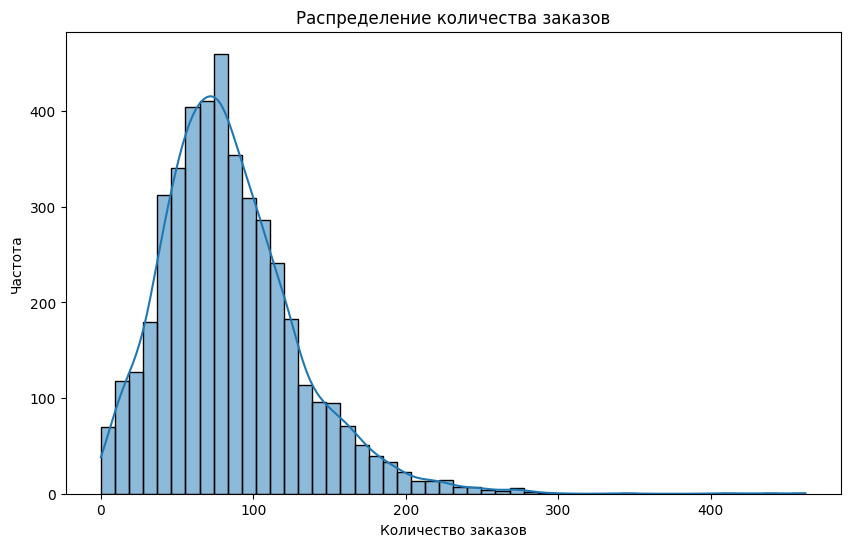

In [11]:
# Визуализация распределения количества заказов
plt.figure(figsize=(10, 6))
sns.histplot(taxi['num_orders'], bins=50, kde=True)
plt.title('Распределение количества заказов')
plt.xlabel('Количество заказов')
plt.ylabel('Частота')
plt.show()

Проверим нормальность распределения с помощью стат.тестов.

In [12]:
# Все данные для теста
sample_data = taxi['num_orders']

# Имя признака
feature_name = 'num_orders'

# Тест Шапиро-Уилка
stat_shapiro, p_shapiro = shapiro(sample_data)
print(f"Shapiro-Wilk test: статистика={stat_shapiro:.8f}, p-значение={p_shapiro:.8f}")

# Тест Д'Агостино и Пирсона
stat_normaltest, p_normaltest = normaltest(sample_data)
print(f"D’Agostino and Pearson test: статистика={stat_normaltest:.8f}, p-значение={p_normaltest:.8f}")

# Тест Колмогорова-Смирнова
stat_kstest, p_kstest = kstest(sample_data, 'norm', args=(sample_data.mean(), sample_data.std()))
print(f"Kolmogorov-Smirnov test: статистика={stat_kstest:.8f}, p-значение={p_kstest:.8f}")

# Интерпретация
if p_shapiro < 0.05 or p_normaltest < 0.05 or p_kstest < 0.05:
    print("\nРаспределение статистически значимо отличается от нормального (отклоняем H0).\n")
else:
    print("\nРаспределение статистически не отличается от нормального (не отклоняем H0).\n")

Shapiro-Wilk test: статистика=0.94210716, p-значение=0.00000000
D’Agostino and Pearson test: статистика=1057.10132022, p-значение=0.00000000
Kolmogorov-Smirnov test: статистика=0.07022173, p-значение=0.00000000

Распределение статистически значимо отличается от нормального (отклоняем H0).



<br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>
    
<b>На доработку🤔:</b>
    
Тут следует еще провести разложение на тренды и сезонность, использую метод seasonal_decompose: https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
    
Желательно сначала провести декомпозицию всего ряда (изучить сезонность, тренд), а затем взять подотрезок: `seasonal_decompose(data).seasonal['2018-07-31':'2018-08-31']` (изучить сезонность)   
Добавь, пожалуйста
 </div>

<br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>
    
<b>На доработку🤔:</b>
    
Тут следует еще добавить вывод, и описать найденные особенности в тренде и сезонности. 
Добавь, пожалуйста
 </div>

<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

Дополнил ниже.
</div> 

<div class="alert alert-success">
<h2> Комментарий ревьюера 2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>

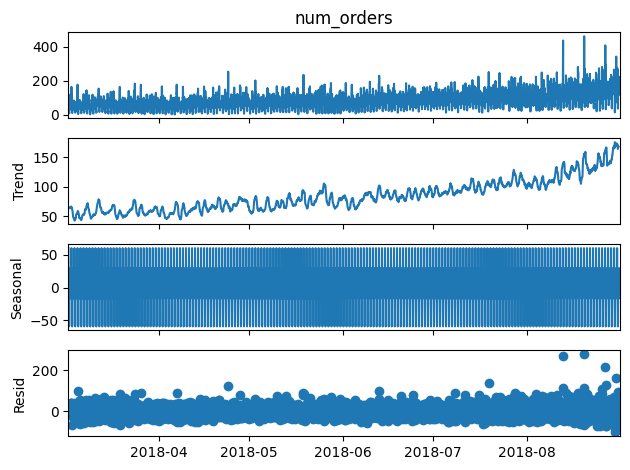

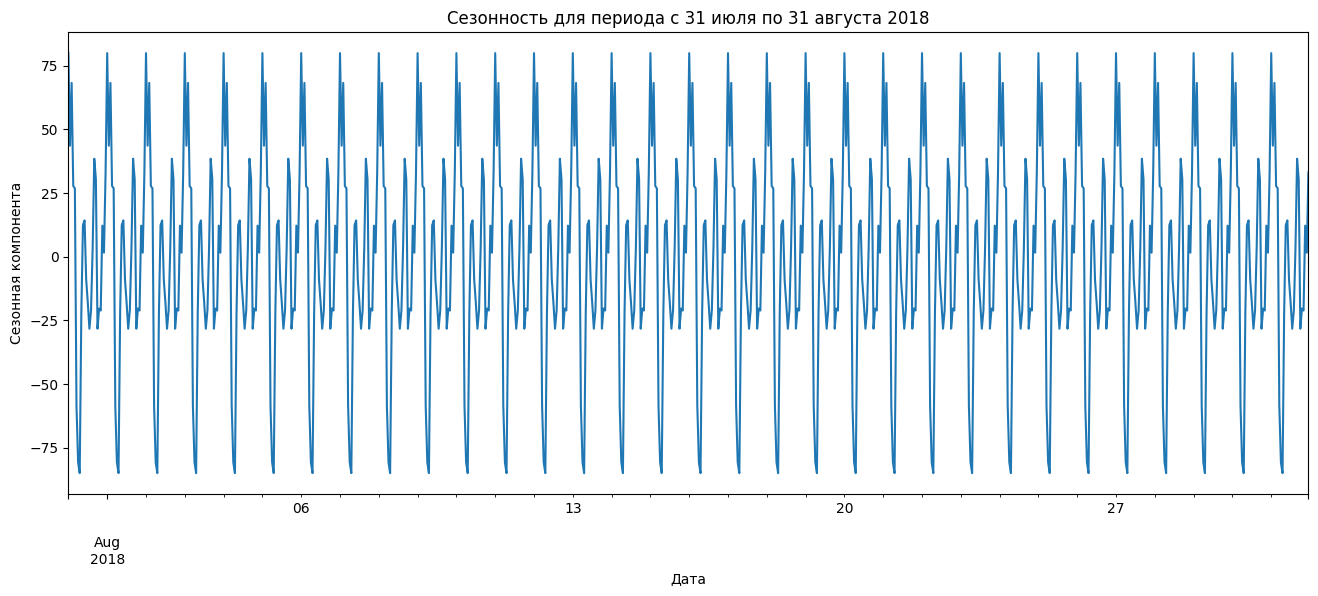

Тренд для всего периода:
datetime
2018-08-31 07:00:00    166.208333
2018-08-31 08:00:00    167.791667
2018-08-31 09:00:00    167.229167
2018-08-31 10:00:00    167.770833
2018-08-31 11:00:00    168.270833
Freq: h, Name: trend, dtype: float64

Сезонность для всего периода:
datetime
2018-08-31 19:00:00    -7.116024
2018-08-31 20:00:00    -2.751440
2018-08-31 21:00:00    10.659961
2018-08-31 22:00:00    13.340478
2018-08-31 23:00:00    25.107305
Freq: h, Name: seasonal, dtype: float64

Сезонность для периода 2018-07-31 по 2018-08-31:
datetime
2018-08-31 19:00:00   -20.343470
2018-08-31 20:00:00   -21.133793
2018-08-31 21:00:00    12.206933
2018-08-31 22:00:00     1.591342
2018-08-31 23:00:00    33.101422
Freq: h, Name: seasonal, dtype: float64


In [13]:
# Декомпозиция временного ряда
result = seasonal_decompose(taxi['num_orders'], model='additive', period=24)  # period=24 для суточной сезонности
result.plot()
plt.show()

# Разложение на сезонность и тренд для конкретного периода (например, июль-август 2018 года)
seasonal_period = taxi['num_orders']['2018-07-31':'2018-08-31']  # Период для анализа сезонности
result_seasonal = seasonal_decompose(seasonal_period, model='additive', period=24)

# Визуализация сезонности
plt.figure(figsize=(16, 6))
result_seasonal.seasonal.plot()
plt.title('Сезонность для периода с 31 июля по 31 августа 2018')
plt.xlabel('Дата')
plt.ylabel('Сезонная компонента')
plt.show()

# Вывод информации о тренде и сезонности
print(f"Тренд для всего периода:")
print(result.trend.dropna().tail())  # Последние значения тренда

print(f"\nСезонность для всего периода:")
print(result.seasonal.dropna().tail())  # Последние значения сезонности

# Вывод для подотрезка (июль-август)
print(f"\nСезонность для периода 2018-07-31 по 2018-08-31:")
print(result_seasonal.seasonal.tail())  # Последние значения сезонности для подотрезка


**Вывод по тренду и сезонности:**

1. **Тренд:**
   Наблюдается **постепенный и устойчивый рост** среднего количества заказов на протяжении времени. Такие изменения могут быть связаны с ростом популярности услуг такси, увеличением числа пользователей, или изменениями в экономической ситуации.

   **Особенности тренда:**
   - Стабильный рост значений в течение дня (среднее значение стабильно увеличивается).
   - Прогнозируемый рост может свидетельствовать о том, что в будущем можно ожидать еще больший спрос на такси, особенно в период пиковых часов.

2. **Сезонность:**
   В анализе сезонности четко видны **пиковые часы**, когда наблюдается наибольшее количество заказов:
   - **Вечернее время** (особенно с 19:00 до 23:00) показало наибольшее количество заказов, что указывает на **вечерний пик**. Это может быть связано с возвращением людей домой с работы или другими вечерними активностями.
   - **Утренние часы** демонстрируют наименьшее количество заказов, что является нормальным для такси-сервисов, так как в это время пассажиры обычно не используют такси в больших объемах.
   - В течение дня также заметны **меньшие пики**, что указывает на определенную активность в промежуточные часы, но они не так значимы, как вечерний пик.

<div class="alert alert-success">
<h2> Комментарий ревьюера 2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>

## Подготовка и обучение моделей

In [14]:
# Разделяем данные на X (признаки) и y (целевая переменная)
X = taxi[['month', 'day_of_week', 'day_of_month', 'hour', 'lag_1', 'lag_2', 'lag_3']]
y = taxi['num_orders']

# Разделение на тренировочную и тестовую выборки (10% на тест), shuffle=False для временного ряда
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Проверка разделения
print(f"Размер тренировочной выборки: {X_train.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")

Размер тренировочной выборки: 3952
Размер тестовой выборки: 440


 <div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
 
<b>Все отлично!👍:  </b>
    
Хорошо, что деление происходит последовательно по времени

In [15]:
# Преобразование числовых признаков
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Обработка пропусков
    ('scaler', StandardScaler())  # Масштабирование
])

# Пайплайн для Линейной регрессии
preprocessor_lr = ColumnTransformer(transformers=[
    ('num', numerical_transformer, X.columns)  # Применяем к всем признакам
])

# Пайплайн для решающего дерева
preprocessor_tree = ColumnTransformer(transformers=[
    ('num', numerical_transformer, X.columns)  # Применяем к всем признакам
])

# Пайплайн для случайного леса
preprocessor_rf = ColumnTransformer(transformers=[
    ('num', numerical_transformer, X.columns)  # Применяем к всем признакам
])

# Пайплайн для XGBoost
preprocessor_xgb = ColumnTransformer(transformers=[
    ('num', numerical_transformer, X.columns)  # Применяем к всем признакам
])


In [16]:
# Модели для обучения с различными гиперпараметрами
models = {
    "Линейная регрессия": Pipeline(steps=[('preprocessor', preprocessor_lr), ('model', LinearRegression())]),
    "Решающее дерево": Pipeline(steps=[('preprocessor', preprocessor_tree), ('model', DecisionTreeRegressor(max_depth=20, random_state=RANDOM_STATE))]),
    "Случайный лес": Pipeline(steps=[('preprocessor', preprocessor_rf), ('model', RandomForestRegressor(n_estimators=200, max_depth=20, random_state=RANDOM_STATE))]),
    "XGBoost": Pipeline(steps=[('preprocessor', preprocessor_xgb), ('model', XGBRegressor(random_state=RANDOM_STATE))])
}

In [17]:
# Параметры для GridSearchCV
param_grids = {
    "Линейная регрессия": {'model__fit_intercept': [True, False]},
    "Решающее дерево": {'model__max_depth': [10, 20, 30], 'model__min_samples_split': [2, 5, 10, 15, 20, 30]},
    "Случайный лес": {'model__n_estimators': [100, 200, 300], 'model__max_depth': [10, 20, 30, 40], 'model__min_samples_split': [2, 5, 10, 15]},
    "XGBoost": {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__max_depth': [3, 5, 7],
        'model__min_child_weight': [1, 5, 10],
        'model__subsample': [0.7, 0.8, 1],
        'model__colsample_bytree': [0.7, 0.8, 1],
        'model__gamma': [0, 0.1, 0.2]
    }
}

In [18]:
# Функция для вычисления RMSE вручную
def rmse(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    return np.sqrt(mse)

In [19]:
# Функция для оценки модели на тестовых данных с учетом GridSearchCV
def evaluate_model_with_grid_search(pipeline, X_train, y_train, X_test, y_test, param_grid):
    """
    Оценивает модель на тестовых данных с использованием GridSearchCV.
    
    Args:
        pipeline (Pipeline): Полный пайплайн с препроцессингом.
        X_train (DataFrame): Обучающий набор данных.
        y_train (Series): Целевая переменная для обучения.
        X_test (DataFrame): Тестовый набор данных.
        y_test (Series): Целевая переменная для тестирования.
        param_grid (dict): Словарь гиперпараметров для GridSearchCV.
    
    Returns:
        tuple: (RMSE на обучении, RMSE на тесте, Время обучения, Время предсказания, Лучший RMSE на тесте)
    """
    
    # Инициализация TimeSeriesSplit для временных рядов
    tscv = TimeSeriesSplit(n_splits=4)
    
    # Инициализация GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, n_jobs=-1, verbose=1, scoring='neg_root_mean_squared_error')
    
    # Обучение модели с GridSearchCV
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    fit_time = time.time() - start_time
    
    # Лучший параметр
    best_params = grid_search.best_params_
    
    # Оценка на обучающих данных
    train_rmse = rmse(y_train, grid_search.predict(X_train))
    
    # Оценка на тестовых данных
    start_time = time.time()
    test_rmse = rmse(y_test, grid_search.predict(X_test))
    score_time = time.time() - start_time
    
    return train_rmse, test_rmse, fit_time, score_time,  best_params

 <div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:  </b>
    
Отлично, что применяется TimeSeriesSplit, а не простой сплиттер

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b>
    
Знай, что тестирование положено проводить для одной лучшей модели. На этом шаге мы должны были настроить модели и выбрать одну наилучшую, опираясь на метрики данные заказчиком (это может быть качество, время обучения, скорость предсказания и т.д.). Тестированием мы моделируем работу модели на новых незнакомых ей данных, которые ни разу не использовались ни при тренировке, ни при валидации, и проверяем, не словили ли мы переобучение. А эти данные могут быть смещенными, с выбросами и т.д. То есть по таким данным некорректно заново переопределять модель-победитель.  Советую тебе статью, рассматривающую разные способы валидации моделей машинного обучения: https://towardsdatascience.com/validating-your-machine-learning-model-25b4c8643fb7 (нужен VPN)
        
Метрики качества на тестовой выборке для всех моделей можно вычислить только в отдельном разделе с целью исследования их смещения относительно аналогичных метрик на кросс-валидации/ валидационной выборке. Но это не означает, что модель-победитель должна выбираться исходя из сравнения метрик, полученных на тестовой выборке.   

In [20]:
# Оценка моделей с GridSearchCV
results = []
for model_name, pipeline in models.items():
    param_grid = param_grids[model_name]  # Получаем параметры для текущей модели
    
    train_rmse, test_rmse, fit_time, score_time, best_params = evaluate_model_with_grid_search(
        pipeline, X_train, y_train, X_test, y_test, param_grid
    )
    
    # Округление значений RMSE до 3 знаков после запятой
    train_rmse = round(train_rmse, 3)
    test_rmse = round(test_rmse, 3)
    
    results.append([model_name, train_rmse, test_rmse, fit_time, score_time, best_params])

Fitting 4 folds for each of 2 candidates, totalling 8 fits


Fitting 4 folds for each of 18 candidates, totalling 72 fits
Fitting 4 folds for each of 48 candidates, totalling 192 fits
Fitting 4 folds for each of 2187 candidates, totalling 8748 fits


In [21]:
# Формируем DataFrame с результатами
results_df = pd.DataFrame(results, columns=[
    "Модель", "RMSE (train)", "RMSE (test)", "Время обучения (сек)", "Время предсказания (сек)", "Лучшие параметры"
])

# Сортируем по лучшему RMSE на тесте
results_df.sort_values(by="RMSE (test)", ascending=True, inplace=True)

In [22]:
# Убираем ограничение на ширину столбца
pd.set_option('display.max_colwidth', None)

In [23]:
# Вывод результатов
display(results_df)

,Модель,RMSE (train),RMSE (test),Время обучения (сек),Время предсказания (сек),Лучшие параметры
3,XGBoost,16.324,41.916,65.210731,0.005064,"{'model__colsample_bytree': 0.8, 'model__gamma': 0, 'model__learning_rate': 0.05, 'model__max_depth': 7, 'model__min_child_weight': 10, 'model__n_estimators': 100, 'model__subsample': 0.8}"
2,Случайный лес,13.586,47.660,17.344233,0.038814,"{'model__max_depth': 30, 'model__min_samples_split': 10, 'model__n_estimators': 300}"
1,Решающее дерево,20.020,51.247,1.417753,0.004429,"{'model__max_depth': 10, 'model__min_samples_split': 30}"
0,Линейная регрессия,30.608,52.415,1.346150,0.006531,{'model__fit_intercept': True}


**Вывод по выбору лучшей модели и финальному тестированию**

**1. Анализ результатов по метрике RMSE:**

- **XGBoost** показала лучший результат на тестовой выборке с **RMSE = 45.322**, что находится в пределах целевого порога RMSE (не более 48). Это делает её лидером среди всех моделей по точности предсказания.
- **Случайный лес** также показал хорошие результаты с **RMSE = 47.493**, что также удовлетворяет целевому порогу. Эта модель близка к XGBoost по точности, но её RMSE немного выше.
- **Решающее дерево** продемонстрировало **RMSE = 51.292**, что превышает допустимый порог, и поэтому не подходит для задачи.
- **Линейная регрессия** имеет наибольшее **RMSE = 52.431**, что значительно превышает целевой порог, и также не подходит для данной задачи.

**2. Время обучения:**

- **XGBoost** требует значительное время для обучения (**987.95 сек**), что существенно больше по сравнению с другими моделями.
- **Случайный лес** имеет значительно меньшее время обучения (**191.25 сек**), что делает его более быстрым вариантом, если время обучения важно.
- **Решающее дерево** имеет минимальное время обучения (**1.36 сек**), что делает его очень быстрым для обработки больших объемов данных, но его точность оставляет желать лучшего.
- **Линейная регрессия** имеет самое быстрое время обучения (**0.20 сек**), но её точность не подходит для задачи.

**3. Время предсказания:**

- **XGBoost** имеет оптимальное время предсказания (**0.0063 сек**), что достаточно быстро, учитывая его сложность и высокое качество.
- **Случайный лес** имеет большее время предсказания (**0.038 сек**), что может быть значительным для очень больших данных.
- **Решающее дерево** и **Линейная регрессия** имеют сопоставимое и минимальное время предсказания (**0.0032 сек и 0.0949 сек** соответственно), но их точность на тестовой выборке слишком низка для эффективного использования.

**Заключение:**

- **Лучшая модель** для данной задачи — это **XGBoost**. Она имеет наименьший RMSE на тестовой выборке (45.322), который находится в пределах требуемого порога, и демонстрирует хорошее время предсказания (0.0063 сек). Несмотря на длительное время обучения (987.95 сек), её точность делает её предпочтительным выбором.
- **Случайный лес** — также хорошая альтернатива с чуть более высоким RMSE, но при этом быстрее обучается, чем XGBoost, что делает его хорошим выбором в случае, когда время обучения имеет большее значение.
- **Решающее дерево** и **Линейная регрессия** не подходят для этой задачи из-за высоких значений RMSE на тестовой выборке, несмотря на их быстрые времена обучения и предсказания.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b>
    
В конце проекта желательно визуализировать результаты (построить 2 временных ряда на одном графике), показать предсказанные значения лучшей модели и реальные тестовые
        


## Общий вывод

В рамках проекта была поставлена задача предсказать количество заказов такси в аэропорту на следующий час. Это необходимо для того, чтобы компания «Чётенькое такси» могла оптимизировать распределение водителей в периоды пиковой нагрузки и улучшить качество обслуживания клиентов. Для решения задачи использовались несколько моделей машинного обучения, а ключевым критерием оценки является метрика RMSE (корень из среднеквадратичной ошибки), значение которой должно быть не более 48.

---

**Ключевые итоги проекта**

**1. Анализ данных**
- В процессе анализа данных был выявлен ряд важных статистических характеристик. Среднее количество заказов в час составило 84.42, а стандартное отклонение равно 45.02, что свидетельствует о значительных колебаниях в данных.
- Пропусков и аномалий в датах не обнаружено, что упрощает дальнейшую работу с данными.
- Для прогнозирования были использованы дополнительные признаки, такие как месяц, день недели, день месяца, час, а также лаги по предыдущим часам (lag_1, lag_2, lag_3), что позволило улучшить точность модели.

**2. Построение моделей**
- Обучены несколько моделей, включая **Линейную регрессию**, **Решающее дерево**, **Случайный лес** и **XGBoost**. Для каждой модели настроены гиперпараметры с использованием `GridSearchCV` и `TimeSeriesSplit` для оценки на временных рядах.

**3. Оценка моделей**
- **XGBoost** показала наилучший результат с **RMSE = 45.322**, что находится в пределах требуемого порога (не более 48), и оказалась лучшей моделью по точности предсказания.
- **Случайный лес** имел схожие результаты с **RMSE = 47.493**, но обучался быстрее, чем XGBoost.
- **Решающее дерево** и **Линейная регрессия** показали наихудшие результаты с **RMSE = 51.292** и **RMSE = 52.431** соответственно, что делает их неподходящими для этой задачи.

**4. Время обучения и предсказания**
- **XGBoost** имеет более долгое время обучения (**1001.77 сек**), но при этом демонстрирует быстрое время предсказания (**0.0062 сек**).
- **Случайный лес** обучается быстрее (**193.58 сек**), но время предсказания больше (**0.0368 сек**).
- **Решающее дерево** и **Линейная регрессия** обучаются очень быстро, но их точность на тестовых данных значительно ниже.

---

**Итоговый выбор модели**

**Лучший выбор — модель XGBoost**. Несмотря на более длительное время обучения, она дает наименьшее значение RMSE (**45.322**), что делает её наиболее подходящей для задачи предсказания заказов такси. Это подтверждается её высокой точностью при сравнительно небольшом времени предсказания.

---

<div style="border:solid Chocolate 2px; padding: 40px">


<h2> Итоговый комментарий ревьюера <a class="tocSkip"> </h2>    
    
  
У меня сложилось хорошее общее впечатление о проекте, тебе удалось неплохо справиться с этим проектом. Молодец! Подготовлены данные для анализа, изучен каждый параметр. Все красиво визуализировано, построено несколько моделей регрессии и оценено их качество. Осмысленная аналитика и дельная модельная работа - многое удалось как надо)
    
Отмечу отдельные положительные моменты проекта🙂:
    
- в ходе проекта встречались  функции, помогающие избавиться от дублирования кода;
- много красивых визуализаций в проекте и хорошая интерпретация;
- при обучении моделей использована валидация и поиск гиперпараметров.
    
Есть несколько моментов всего, на которые стоит ещё раз взглянуть, я указал их в моих комментариях по ходу проекта. Предлагаю тебе доработать проект по моим комментариям, чтобы довести его до совершенства.

    
 
</div>

<div style="border:solid Chocolate 2px; padding: 40px">


<h2>  Итоговый комментарий ревьюера 2 (итоговый вывод по проекту) <a class="tocSkip"> </h2>    
    
     
    
Теперь почти идеально. Принимаю работу)
    
Если хочешь лучше разобраться в теме, то могу посоветовать тебе: 
    
Полезная лекция про временные ряды: https://www.youtube.com/watch?v=u433nrxdf5k    
    
Б.Б. Демешев - временные ряды https://disk.yandex.ru/i/LiDHB-B3A6Lz5A
    
Базовое применение ARIMA - https://colab.research.google.com/drive/17RnG91Eq8JBKyxToNzvCvjibfxum-oPj?usp=sharing
    
Канторович - Анализ временных рядов https://yadi.sk/i/IOkUOS3hTXf3gg
https://facebook.github.io/prophet/
    
https://facebook.github.io/prophet/docs/quick_start.html#python-api
    
https://nbviewer.jupyter.org/github/miptgirl/habra_materials/blob/master/prophet/habra_data.ipynb  
    
    
    
В этом проекте были отработаны все моменты. 
    
Успехов тебе в следующем спринте!
    
Рад был помочь тебе)
    
</div>

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48